In [11]:
import gdown
folder_id = "1mpMqGYcjkQ7g_q4eW0WVmnnXqGe-mNvU"
dest="../data/gaza_molnar"
!mkdir -p $dest
gdown.download_folder(url=f"https://drive.google.com/drive/folders/{folder_id}", output=dest, quiet=False)

Retrieving folder contents


Retrieving folder 1vBTwW0Et5E4Sjcf8vWfWC7zjiy6P18mT palestine_admin_bounds
Processing file 1W3TGQ0brmFdjAfZkcGsTjAWyedibYnay .DS_Store
Processing file 1QJZ9cvKntZjwibbCc9GOFyHB43JUwpG5 pse_admbnda_adm2_pamop_20231019.cpg
Processing file 1Ut3_wXDcs4dF-SBLSijBXDPHEp7UNdQ4 pse_admbnda_adm2_pamop_20231019.dbf
Processing file 16PxbrrLow8XkwFSkslkSdtZlbginF3v8 pse_admbnda_adm2_pamop_20231019.prj
Processing file 1UbHovf_RcrscxEucggDhWbryYN9udRWA pse_admbnda_adm2_pamop_20231019.sbn
Processing file 1zJ9CAbjgwazO1g56mqVG5rmfMOVpDwc7 pse_admbnda_adm2_pamop_20231019.sbx
Processing file 1DPu9aemGhlPLP0hAWcAm3FIBxjT85LU1 pse_admbnda_adm2_pamop_20231019.shp
Processing file 1IqYNJoOpIsJTMrhPnZV-m0VsFFKzDUbP pse_admbnda_adm2_pamop_20231019.shp.xml
Processing file 192eOoCdVPmZ1wnWE6ZbG8ryMe_D0Qmhj pse_admbnda_adm2_pamop_20231019.shx
Processing file 1xrjd9A4-fr0mnliEmHElP_Aenx46Nu-R Gaza_20231010_1_grid.csv
Processing file 1SLrJxU9IGXefkiK1hIBFEn64vuCDYMC1 Gaza_20231110_1_grid.csv
Processing file 1gs-ERg

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1W3TGQ0brmFdjAfZkcGsTjAWyedibYnay
To: /Users/ollieballinger/Google Drive/Work/UCL/Research/Damage Detection/PWTT/data/gaza_molnar/palestine_admin_bounds/.DS_Store
100%|██████████| 6.15k/6.15k [00:00<00:00, 6.79MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QJZ9cvKntZjwibbCc9GOFyHB43JUwpG5
To: /Users/ollieballinger/Google Drive/Work/UCL/Research/Damage Detection/PWTT/data/gaza_molnar/palestine_admin_bounds/pse_admbnda_adm2_pamop_20231019.cpg
100%|██████████| 5.00/5.00 [00:00<00:00, 4.76kB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ut3_wXDcs4dF-SBLSijBXDPHEp7UNdQ4
To: /Users/ollieballinger/Google Drive/Work/UCL/Research/Damage Detection/PWTT/data/gaza_molnar/palestine_admin_bounds/pse_admbnda_adm2_pamop_20231019.dbf
100%|██████████| 6.53k/6.53k [00:00<00:00, 9.18MB/s]
Downloading...
From: https://drive.google

['../data/gaza_molnar/palestine_admin_bounds/.DS_Store',
 '../data/gaza_molnar/palestine_admin_bounds/pse_admbnda_adm2_pamop_20231019.cpg',
 '../data/gaza_molnar/palestine_admin_bounds/pse_admbnda_adm2_pamop_20231019.dbf',
 '../data/gaza_molnar/palestine_admin_bounds/pse_admbnda_adm2_pamop_20231019.prj',
 '../data/gaza_molnar/palestine_admin_bounds/pse_admbnda_adm2_pamop_20231019.sbn',
 '../data/gaza_molnar/palestine_admin_bounds/pse_admbnda_adm2_pamop_20231019.sbx',
 '../data/gaza_molnar/palestine_admin_bounds/pse_admbnda_adm2_pamop_20231019.shp',
 '../data/gaza_molnar/palestine_admin_bounds/pse_admbnda_adm2_pamop_20231019.shp.xml',
 '../data/gaza_molnar/palestine_admin_bounds/pse_admbnda_adm2_pamop_20231019.shx',
 '../data/gaza_molnar/Gaza_20231010_1_grid.csv',
 '../data/gaza_molnar/Gaza_20231110_1_grid.csv',
 '../data/gaza_molnar/Gaza_20231210_1_grid.csv',
 '../data/gaza_molnar/Gaza_20240110_1_grid.csv',
 '../data/gaza_molnar/Gaza_20240210_1_grid.csv',
 '../data/gaza_molnar/Gaza_202

In [8]:
import pwtt
import ee
ee.Initialize(project='ggmap-325812')
gaza = ee.Geometry.Rectangle([34.21,31.21,34.57,31.60])

pwtt.filter_s1(aoi=gaza,
                   war_start='2023-10-10',
                   inference_start='2024-12-01',
                   pre_interval=12,
                   post_interval=1,
                   viz=True)

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

<Axes: xlabel='date', ylabel='ADM2_EN'>

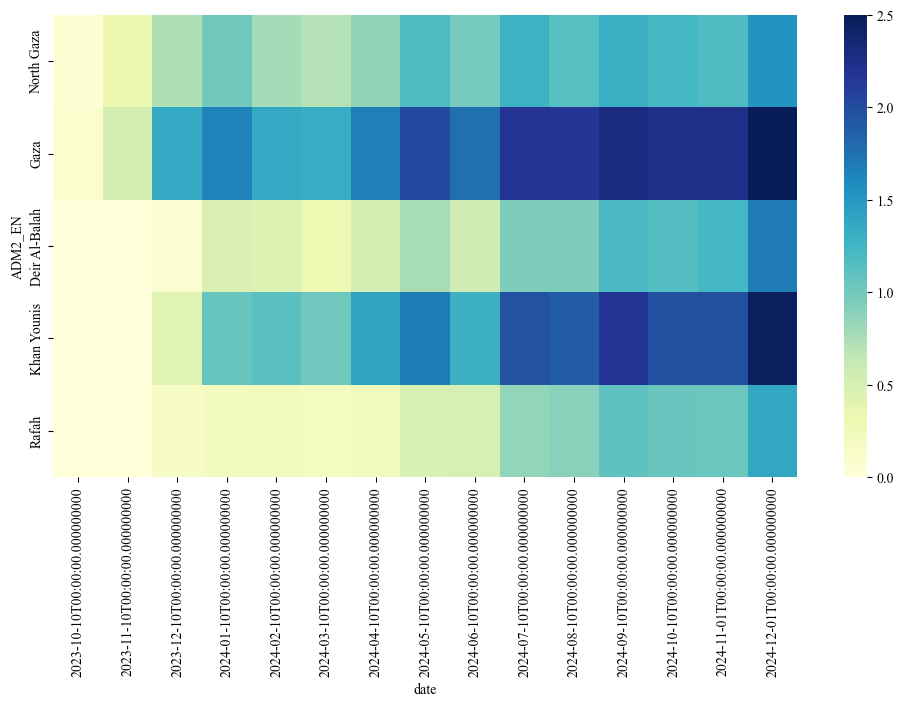

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape
import json
import numpy as np

dest="../data/gaza_molnar"

df=pd.DataFrame()
for root, dirs, files in os.walk(dest):
    for file in files:
        if file.endswith(".csv"):
            temp = pd.read_csv(os.path.join(root, file))
            date=file.split("_")[1]
            temp["date"]=pd.to_datetime(date)
            df=pd.concat([df,temp])

df.reset_index(inplace=True)
df.rename(columns={"index":"grid_id"},inplace=True)
df.sort_values(by=['grid_id','date'],inplace=True)

df['cumsum']=np.where(df['k50']>3,1,0)

df['geometry'] = df['.geo'].apply(lambda x: shape(json.loads(x)))
gdf=gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:3857")
adm=gpd.read_file("../data/palestine_admin_bounds/pse_admbnda_adm2_pamop_20231019.shp")
adm=adm.to_crs("EPSG:3857")
adm=adm[adm['ADM1_PCODE']=='PS02'][['geometry','ADM2_EN']]
order=adm['ADM2_EN'].unique()

gdf=gpd.sjoin(gdf, adm, how="inner")
grouped=gdf.groupby(['ADM2_EN','date'])['cumsum'].sum().unstack().T
grouped=grouped[order].T
min_=grouped.min().min()
max_=grouped.max().max()
#normalize from 0 to 2
#grouped=(grouped-min_)/(max_-min_)*2.5
grouped=(grouped-min_)/(max_-min_)*2.5

array=grouped.to_numpy()
#add column of zeros to the left
array=np.hstack((np.zeros((array.shape[0],1)),array[:,:-1]))
plt.figure(figsize=(12,6))
sns.heatmap(grouped, cmap="YlGnBu")

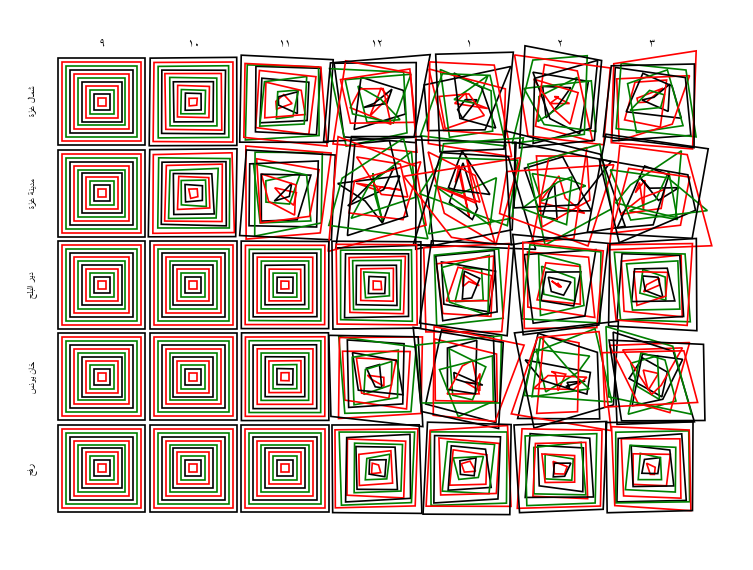

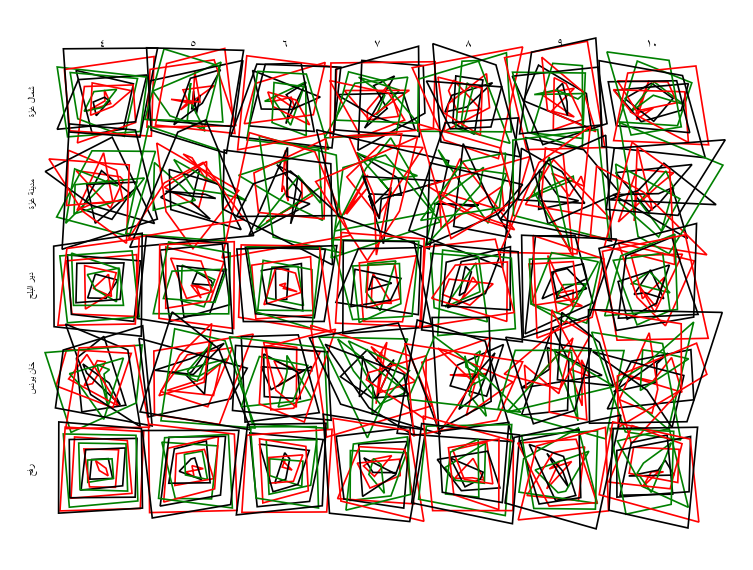

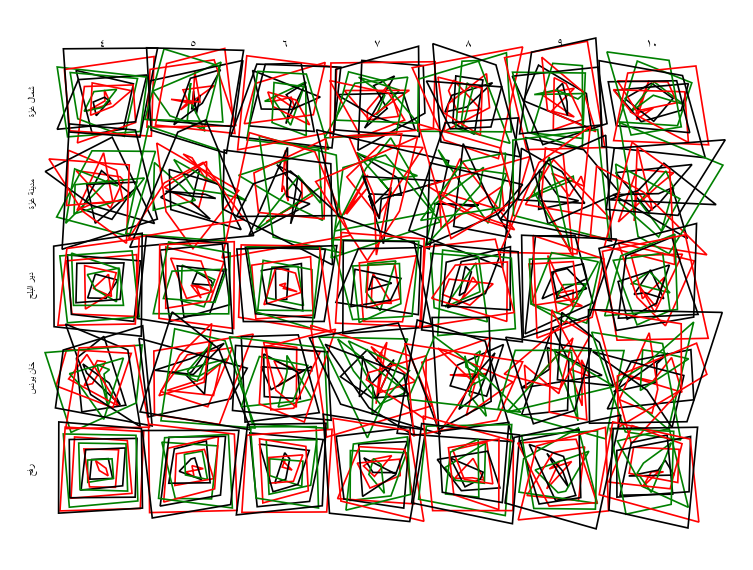

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
from matplotlib import rcParams
import os
import arabic_reshaper
from bidi.algorithm import get_display

# Create directory for saving transformations
os.makedirs("../figs/transformations", exist_ok=True)

def make_polygon(ax, center_x, center_y, width=.5, height=.5, scaling_factor=0.1, color=False):
    """
    Draw nested polygons with random corner adjustments.
    """
    colors=['red','black','green']
    for i in range(11):  # Number of polygons
        cw, ch = width + i * 0.5, height + i * 0.5  # Incremental scaling
        offsets = {corner: (np.random.uniform(-scaling_factor, scaling_factor),
                            np.random.uniform(-scaling_factor, scaling_factor))
                   for corner in ['top_left', 'top_right', 'bottom_right', 'bottom_left']}
        vertices = [
            (center_x - cw / 2 + offsets["top_left"][0], center_y + ch / 2 + offsets["top_left"][1]),
            (center_x + cw / 2 + offsets["top_right"][0], center_y + ch / 2 + offsets["top_right"][1]),
            (center_x + cw / 2 + offsets["bottom_right"][0], center_y - ch / 2 + offsets["bottom_right"][1]),
            (center_x - cw / 2 + offsets["bottom_left"][0], center_y - ch / 2 + offsets["bottom_left"][1])
        ]
        if color:
            c=colors[i%3]
        else:
            c='black'

        ax.add_patch(Polygon(vertices, closed=True, facecolor='none', edgecolor=c, linewidth=lw))

def create_polygons(grid_size=(5, 12), width=.5, height=.5, spacing=3, scaling_factors=None, paper='a3', color=False, page=1):
    """
    Draw polygons on a grid with different scaling factors for each cell.
    """
    if scaling_factors is None:
        # If no scaling factors are provided, use a default factor
        scaling_factors = np.full(grid_size, 0.1)

    #fig, ax = plt.subplots(figsize=(16.5,11.7))  # Adjust figsize as per the grid size
    names=['شمال غزة','مدينة غزة','دير البلح','خان يونس','رفح']
    names=[get_display(arabic_reshaper.reshape(name)) for name in names]

    #headers=["09","10","11","12","01","02","03","04","05","06","07","08","09","10"]
    headers=['٩','١٠','١١','١٢','١','٢','٣','٤','٥','٦','٧','٨','٩','١٠']
    headers=[get_display(arabic_reshaper.reshape(name)) for name in headers]
    #headers = ["صفر", "ربيع الأول", "ربيع الآخر", "جمادى الأولى", "جمادى الآخرة", "رجب", "شعبان", "رمضان", "شوال", "ذو القعدة", "ذو الحجة", "المحرم", "صفر", "ربيع الأول"]

    fig, ax = plt.subplots(figsize=(w,h))  # Adjust figsize as per the grid size
    
    for i in range(grid_size[0]):  # Iterate over rows
        ax.text(-4, -i * spacing, names[i], ha='right', va='center', fontsize=fontsize, rotation=90)
        for j in range(grid_size[1]):  # Iterate over columns
            scaling_factor = scaling_factors[i, j]  # Get the scaling factor for this cell
            make_polygon(ax, center_x=j * spacing, center_y=-i * spacing,
                         width=width, height=height, scaling_factor=scaling_factor, color=color)
            if i==0:
                if page>1:
                    k=j+colnum
                else:
                    k=j
                if paper=='a3':
                    ax.text(j * spacing, h*.35, headers[k], ha='center', va='center', fontsize=fontsize+4)
                else:
                    ax.text(j * spacing, h*.6, headers[k], ha='center', va='center', fontsize=fontsize+2)

    ax.set_xlim([-spacing, grid_size[1] * spacing])  # Adjust x-axis limits
    ax.set_ylim([-grid_size[0] * spacing, spacing])  # Adjust y-axis limits
    ax.set_aspect('equal')
    
    ax.axis('off')
    fig.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02)
    fig.tight_layout()
    fig.savefig(f"../figs/transformations/transformations_gaza_{paper}_{page}.png", dpi=dpi, bbox_inches='tight')
    plt.show()
    return fig

# Example scaling factors for each grid cell (5 rows x 12 columns)
scaling_factors = np.random.uniform(0.05, 0.2, (5, 12))  # Random scaling factors

#rcParams['font.family'] = 'monospace'
rcParams['font.family'] = 'Times New Roman'


paper='a5'
colnum=7

if paper=='a3':
    w,h=16.5,11.7
    lw=2.5
    fontsize=12
    dpi=500
    spacing=5.79
elif paper=='a4':
    w,h=11.7,8.3
    lw=1
    fontsize=8
elif paper=='a5':
    w,h=8.3,5.8
    lw=1.2
    fontsize=7
    dpi=1000
    spacing=5.77


create_polygons(grid_size=(5,colnum), paper=paper, spacing=spacing, scaling_factors=array[:,:colnum],page=1, color=True)
create_polygons(grid_size=(5,colnum), paper=paper, spacing=spacing, scaling_factors=array[:,colnum:], page=2,color=True)
